Cross-correlate CMB lensing and LSS.

In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np

repoDir= os.getcwd()
os.chdir(os.path.join(repoDir, '..' ))
repoDir= os.getcwd()
#sys.path.append(repoDir)
sys.path.insert(0,repoDir+'/CAMB/CAMB-Jan2017/pycamb')
import camb
from camb import model, initialpower

from orphics.theory.cosmology import LimberCosmology

import healpy as hp
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
lmax= 1000
nside= 4
H0= 67.0; w0= -1.
ombh2=0.022; omch2=0.1194; mnu=0.06; omk=0; tau=0.06
ns= 0.96; r=0; As= 2.2e-9
kmax= 42.47      # from LimberCosmology   
numz= 100.

Currently, not following the plan in the meeting notes as getting things from the density field $\delta(x,z)$.

Follow the methodology in orphics, where

$C_\ell^{\kappa \kappa}= \int dz \frac{H(z)}{\chi^2 c^2}W^c(z)W^c(z)\chi P(k(\ell,z),z)$

$C_\ell^{\kappa g}= \int dz \frac{H(z)}{\chi^2 c^2}W^g(z)W^c(z)\chi P(k(\ell,z),z)$
- ^^ Doesn't match with the cross equation in the write up: $C_\ell^{\kappa g}= \int_0^\infty dz W^g(z)W^c(z)b(z)P^{true}_\ell(k, z)$
         
By extension, we'd have
$C_\ell^{g g}= \int dz \frac{H(z)}{\chi^2 c^2}W^g(z)W^g(z)\chi P(k(\ell,z),z)$


#### we will be considering z-bins and not just full 0-$\infty$ range.

In [3]:
# set up parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2= ombh2, omch2=omch2, mnu=mnu, tau=tau)
pars.set_dark_energy(w= w0)
pars.InitPower.set_params(ns= ns, As= As)

In [4]:
# modified from to Limbercosmology.generateCls
results= camb.get_background(pars)

chistar = results.conformal_time(0)- model.tau_maxvis.value
zstar = results.redshift_at_comoving_radial_distance(chistar)   # decoupling z

chis = np.linspace(0, chistar, numz)

dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs= results.redshift_at_comoving_radial_distance(chis)

zmax= max(zs)

/Users/Humna/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


In [5]:
# get P(k,z) interpolator
Pk_intep= camb.get_matter_power_interpolator(pars,
                                             nonlinear= True, hubble_units=False,
                                             k_hunit=False, 
                                             kmax= kmax, zmax= zmax, return_z_k= False)

###  Get $W^c(z)$

In [6]:
# help(LimberCosmology)

In [7]:
def plot(x, y, xlabel, ylabel, sci= False):
    plt.clf()
    plt.plot(x, y)
    plt.xlabel(xlabel, fontsize= 18)
    plt.ylabel(ylabel, fontsize= 18)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    #plt.xlim(0,500)
    #plt.ylim(0,0.00002)
    if sci: plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig= plt.gcf()
    #fig.set_size_inches(10.5, 7.5)
    plt.show()

Generating theory Cls...
Initializing CMB window..
initializing power...


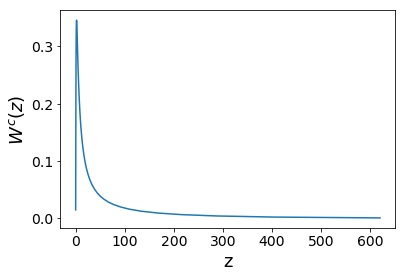

In [8]:
limber= LimberCosmology(lmax= lmax)

W_c= limber.kernels['cmb']['W']

plot(zs, W_c, 'z', '$W^c(z)$')

###### Why so not a top-hat for low-z?

In [9]:
Wc_interp = scipy.interpolate.splrep(zs, W_c, s=0)
def Wc(z): return scipy.interpolate.splev(z, Wc_interp, der=0)

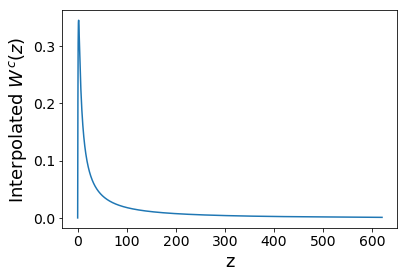

In [10]:
# interpolate
znew = np.arange(0, zmax, 0.5)
plot(znew, Wc(znew), 'z', 'Interpolated $W^c(z)$')

### Set up $W^g(z)$
#### Asume $W^g$ is 1 for all z-bins rn.

In [11]:
def Wg(z): return np.ones(len(np.array(z)))

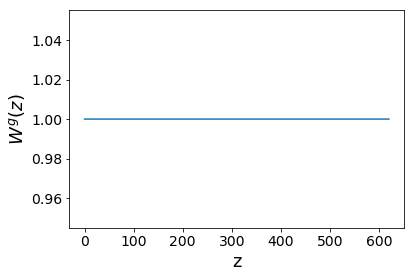

In [12]:
plot(znew, Wg(znew), 'z', '$W^g(z)$')

In [13]:
W= {}
W['g']= Wg
W['k']= Wc

###  Get the power specta, $C_\ell^{\kappa \kappa}, C_\ell^{\kappa g}, C_\ell^{g g}$ using the equations above.

In [14]:
Hzs = np.array([results.hubble_parameter(z) for z in zs])
cSpeedKmPerSec = 299792.458

prefactor= Hzs**2. /chis/chis/cSpeedKmPerSec**2.

In [15]:
listKeys = zip(['g', 'g' ,'k'],['g', 'k', 'k'])

ellrange= np.arange(0, lmax)

Cell = {}
for key1, key2 in listKeys:
    Cell[key1+key2] = []
    
Cell

{'gg': [], 'gk': [], 'kk': []}

In [16]:
w = np.ones(chis.shape)

zmin= 0 ### 

for ell in ellrange:
    k=(ell+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>= kmax]=0
    
    pkin = Pk_intep.P(zs, k, grid=False)
    common = ((w*pkin)*prefactor)[zs>=zmin]

    for key1, key2 in listKeys:
        estCl = np.dot(dchis[zs>=zmin], common*(W[key1](zs)*W[key2](zs))[zs>=zmin])
        Cell[key1+key2]= np.hstack((Cell[key1+key2], estCl))        
for key1, key2 in listKeys:
    Cell[key1+key2] = np.array(Cell[key1+key2])

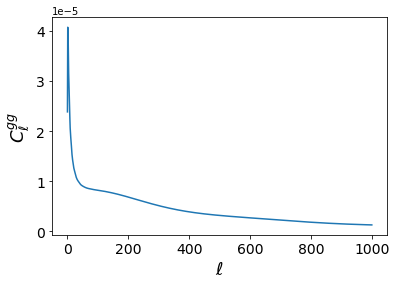

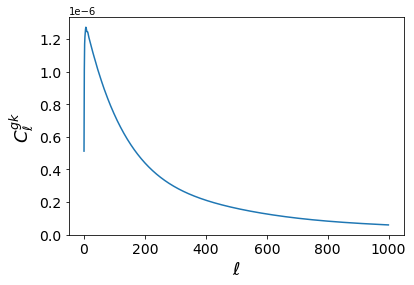

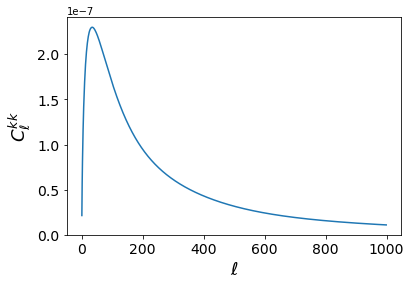

In [17]:
for key1,key2 in listKeys:
    plot(ellrange, Cell[key1+key2], xlabel= '$\ell$', 
         ylabel= '$C_\ell^{%s%s}$'%(key1,key2), sci= True)

In [18]:
#help(camb.get_matter_power_interpolator)

### Now use synfast to realize the covergence and density fields. Assume T, E, B= g, $\kappa$, 0??

In [19]:
nside= 512
zeroArr= Cell['gg']-Cell['gg']
TT, EE, BB= Cell['gg'], Cell['kk'], zeroArr
TE, EB, TB=  Cell['gk'], zeroArr, zeroArr

maps= {}
maps['g'], maps['k'], maps['unsure?']= hp.synfast(cls= [TT, EE, BB, TE, EB, TB],  # I, Q, U
                                                    nside= nside, lmax= lmax, new=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


##### not sure what the third map is for ..  :/

In [20]:
def skymap(data, title, minC= -0.12, maxC= 0.12):
    plt.clf()
    hp.mollview(data, flip= 'astro', rot=(0,0,0),
                title= title,
                cbar=True, min= minC, max= maxC)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

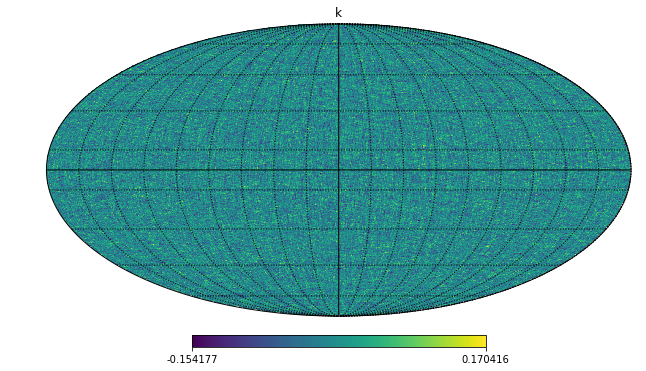

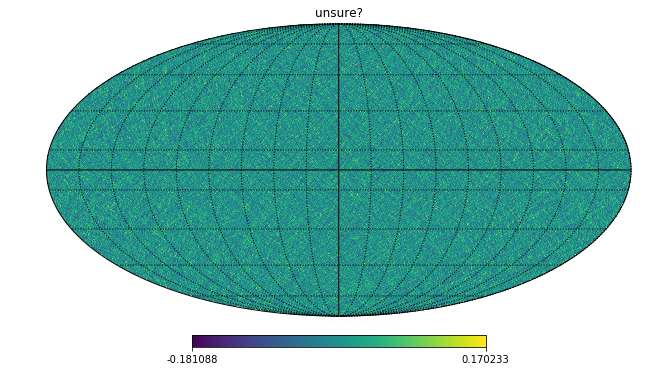

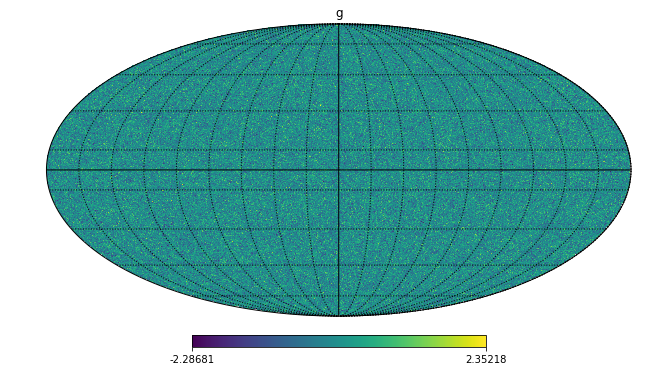

In [21]:
for key in maps:
    skymap(maps[key], key, minC= None, maxC= None)

#### g-range is larger? Ok?

See if can recover the power spectra with these three maps.

In [22]:
def autopowerspec(data, remove_monopole= False):
    if remove_monopole:
        return hp.anafast(hp.remove_monopole(data), lmax= lmax)
    else:
        return hp.anafast(data, lmax= lmax)

In [23]:
def plotMore(xs, ys, xlabel, ylabel, sci= False):
    plt.clf()
    for key in xs:
        plt.plot(xs[key], ys[key], label= key)
    plt.xlabel(xlabel, fontsize= 18)
    plt.ylabel(ylabel, fontsize= 18)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.legend()
    #plt.xlim(0,500)
    #plt.ylim(0,0.00002)
    if sci: plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig= plt.gcf()
    #fig.set_size_inches(10.5, 7.5)
    plt.show()

In [24]:
def auto(gType):
    key1, key2= gType, gType
    
    xs,ys= {}, {}

    key= 'From Map'
    ys[key]= autopowerspec(maps[key1])
    xs[key]= np.arange(0, len(ys[key]))

    key= 'From Map; no monopole'
    ys[key]= autopowerspec(maps[key1], remove_monopole= True)
    xs[key]= np.arange(0, len(ys[key]))

    key= 'From before'
    ys[key]= Cell[key1+key2]
    xs[key]= np.arange(0, len(ys[key]))
    
    plotMore(xs, ys,  xlabel= '$\ell$', ylabel= '$C_\ell^{%s%s}$'%(key1,key2),  sci= True)

monopole: -0.00261414


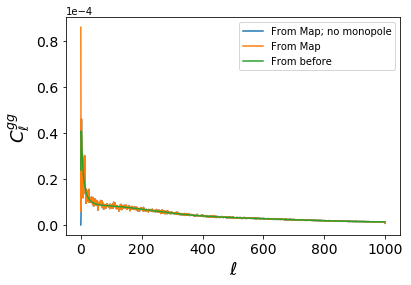

In [25]:
auto('g')

monopole: 0.000102521


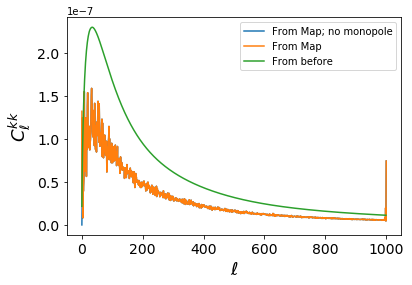

In [26]:
auto('k')

#### Ok monopole doesnt matter but independent usage isn't helping.

#### Using all three maps together might be better.

In [27]:
TT_new, EE_new, BB_new, TE_new, EB_new, TB_new= hp.anafast([maps['g'], maps['k'], maps['unsure?']], lmax= lmax)

In [28]:
def plotNew(new, old, ylabel):
    xs,ys= {}, {}
    key= 'From Map'
    ys[key]= new
    xs[key]= np.arange(0, len(ys[key]))
    key= 'From before'
    ys[key]= old
    xs[key]= np.arange(0, len(ys[key]))
    plotMore(xs, ys,  xlabel= '$\ell$', ylabel= ylabel,  sci= True)

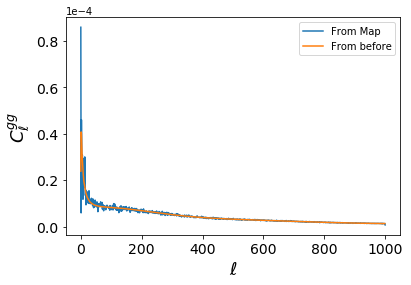

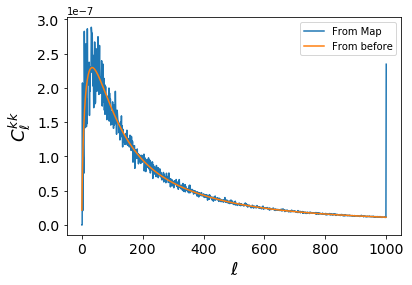

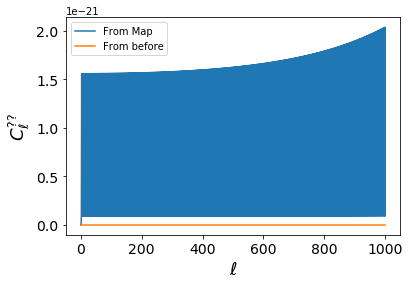

In [29]:
key1,key2= 'g', 'g'
plotNew(TT_new, Cell[key1+key2],  '$C_\ell^{%s%s}$'%(key1,key2))

key1,key2= 'k', 'k'
plotNew(EE_new, Cell[key1+key2],  '$C_\ell^{%s%s}$'%(key1,key2))

key1,key2= '?', '?'
plotNew(BB_new, zeroArr,  '$C_\ell^{%s%s}$'%(key1,key2))

Ok ok .. ?? one is the weirdest.

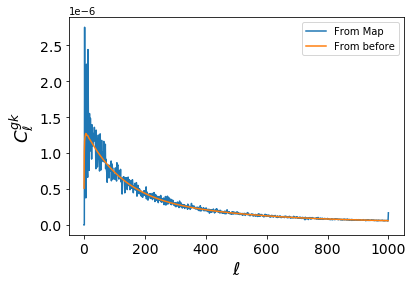

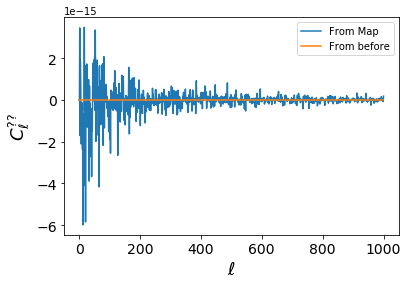

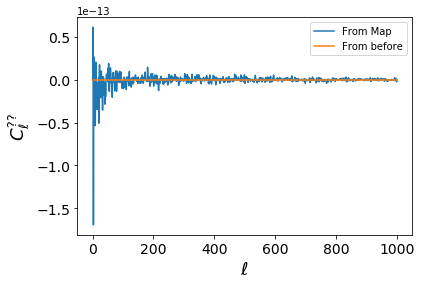

In [30]:
key1,key2= 'g', 'k'
plotNew(TE_new, Cell[key1+key2],  '$C_\ell^{%s%s}$'%(key1,key2))

key1,key2= '?', '?'
plotNew(EB_new, zeroArr,  '$C_\ell^{%s%s}$'%(key1,key2))

key1,key2= '?', '?'
plotNew(TB_new, zeroArr,  '$C_\ell^{%s%s}$'%(key1,key2))

Looks ok.